## find_remaining_variables.ipynb

In this notebook, we find various variables for politicians and non-politicians. We first extract all election- and election-history related data. For the non-politicians, the names come directly from the elections data. Hence, we do not have to string match. For the politicians, we have to match the names of the politicians to the names in the elections dataset. 

Secondly, we extract demographic and district data 

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import re
from itertools import compress

from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns

from rdrobust import rdrobust,rdbwselect,rdplot

/home/bas/anaconda3/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.


In [2]:
# Read the data
data = pd.read_csv("../Data/analysis/unmatched_sample_analysis.csv", dtype={'b1-nummer':str}).iloc[:,1:]
# (or some other dataset)
data.head(5)

,b1-nummer,Naam,District,Verkiezingdatum,Vermogen,margin,Sterfdatum,Vermogen_deflated
0,01100,R. de Sitter,Winschoten,30/11/1848,NaN,0.071839,24-02-1869,NaN
1,01527,R. Westerhoff,Appingedam,27/12/1848,NaN,0.136499,25-03-1874,NaN
2,00955,J.T. Homan,Assen,30/11/1848,NaN,0.087193,29-03-1852,NaN
3,01100,G. de Serière,Hoogeveen,26/12/1848,NaN,0.030981,24-02-1869,NaN
4,00332,D. Donker Curtius,Almelo,02/01/1849,NaN,0.112500,17-07-1864,NaN
5,01316,C.M. Storm van 's Gravesande,Enschede,30/11/1848,538774.18,0.096639,08-07-1880,395608.196401
6,00872,M.J. de Man,Enschede,16/12/1848,NaN,0.148225,22-12-1854,NaN
7,01361,J.R. Thorbecke,Zutphen,30/11/1848,NaN,0.137143,04-06-1872,NaN
8,01504,S. van Walchren,Amersfoort,30/11/1848,NaN,0.007092,16-01-1871,NaN
9,01504,S. van Walchren,Amersfoort,07/12/1848,NaN,0.189504,16-01-1871,NaN


## Explore the balance of observations

We take the data frame as a whole, but also as an observation for each observation in the control group

In [3]:
# All non-NA obs.
print("All observations", data[-data['Vermogen_deflated'].isnull()].shape)


# Control group
print("Control group:", 
      data[(-data['Vermogen_deflated'].isnull()) & (data['b1-nummer'].isnull())].shape
     )


# Treatment group
print("Treatment group:", 
      data[(-data['Vermogen_deflated'].isnull()) & (-data['b1-nummer'].isnull())].shape
     )

All observations (611, 8)
Control group: (263, 8)
Treatment group: (348, 8)


## Variable pick up function

We write a function that picks up all required variables, first for all observations, then for politicians and then for non-politicians. 

In [4]:
def cleanup(x):
    'Helper to clean up politicians birthplace'
    step1 = re.sub('\((.+)\)', '', x)
    step2 = re.sub("'s-Gravenhage", 'Den Haag', step1)
    step3 = re.sub("'s-Hertogenbosch", "Den Bosch", step2)
    step4 = step3.strip()
    
    return step3

In [5]:
# Election and election history data
## Some datasets which I need
electoral_data = pd.read_csv("../Data/elections/election_results_details.csv").iloc[:,1:]
electoral_data.iloc[:,[2,7,8,9,10,11,12,13]] = electoral_data.iloc[:,[2,7,8,9,10,11,12,13]].apply(lambda x: pd.to_numeric(x, errors='coerce'))
electoral_data['Verkiezingdatum'] = electoral_data['Verkiezingdatum'].apply(lambda x: pd.Timestamp(x))

## Seats data
zetels = electoral_data.groupby(['District', 'Verkiezingdatum']).agg({'Aantal zetels': 'mean'})

## Politician metadata
politician_metadata = pd.read_excel("../Data/politician_data/tk_1815tot1950uu.xlsx", dtype={'b1-nummer':str})
politician_metadata2 = pd.read_excel("../Data/politician_data/tk_1815tot1950uu.xlsx", sheet_name = 1, dtype={'b1-nummer':str})

### Clean up the variable 'waarde' (birthplace from politician metadata)
politician_metadata2['waarde'] = politician_metadata2['waarde'].apply(lambda x: cleanup(x))

## Nonpolitician metadata
nonpolitician_metadata = pd.read_csv("../Data/nonpolitician_data/nonpoliticians_birthplace_birthdates.csv").iloc[:,1:]

## Taxes and population (district)
taxes_pop = pd.read_csv('../Data/district_data/taxes_and_population.csv').iloc[:,1:]

## Religious composition over time (district)
religious_comp = pd.read_csv("../Data/district_data/religion_over_time.csv").iloc[:,1:]

## Professional composition 1889 (district)
prof_comp = pd.read_csv("../Data/district_data/professional_composition.csv").iloc[:,1:]


In [6]:
nonpolitician_metadata.head(5)

,Naam,Birthplace,Birthdate
0,mr. J. van Riemsdijk,Enschede,07/04/1811
1,W. de la Haye,Sittard,03/02/1829
2,D. Mulder Dzn.,Winschoten,27/11/1825
3,mr. S.J. baron van Pallandt,Den Haag,17/12/1843
4,H.P. Gelderman,Losser,06/11/1808


In [7]:
electoral_data.head(5)

,Naam,Aanbevolen door,Aantal stemmen,Procentueel,District,Verkiezingdatum,Type,Omvang electoraat,Opkomst,Aantal stembriefjes,Aantal stemmen geldig,Aantal stemmen blanco,Aantal zetels,Kiesdrempel
0,mr. B. Wichers,NaN,700.0,83.73%,Groningen,1848-11-30,algemeen,1191,838.0,838.0,836.0,0.0,1.0,418.0
1,W.L. de Sturler,NaN,34.0,4.07%,Groningen,1848-11-30,algemeen,1191,838.0,838.0,836.0,0.0,1.0,418.0
2,mr. A. Oudeman,NaN,22.0,2.63%,Groningen,1848-11-30,algemeen,1191,838.0,838.0,836.0,0.0,1.0,418.0
3,L.T. Jorissen,NaN,21.0,2.51%,Groningen,1848-11-30,algemeen,1191,838.0,838.0,836.0,0.0,1.0,418.0
4,jhr.mr. O.Q.J.J. van Swinderen,NaN,14.0,1.67%,Groningen,1848-11-30,algemeen,1191,838.0,838.0,836.0,0.0,1.0,418.0


In [8]:
politician_metadata.head(5)

,b1-nummer,achternaam,voorletters,voorna(a)m(en),roepnaam,prepositie,geslacht,partij(en)/fractie(s),begin periode,einde periode
0,04000,Andringa de Kempenaer,A.A.,Antoon Anne,NaN,van,m,regeringsgezinden ten tijde van Willem I,1815-09-21,1825-06-12
1,04001,Roorda van Eysinga,S.H.,Schelto Hessel,NaN,NaN,m,financiële oppositie,1815-09-21,1822-10-20
2,04002,Lycklama à Nijeholt,T.M.,Tinco Martinus,NaN,NaN,m,regeringsgezinden ten tijde van Willem I,1815-09-21,1831-10-16
3,04003,Sminia,H.,Hector,NaN,van,m,regeringsgezinden ten tijde van Willem I,1815-09-21,1816-10-30
4,04004,Sytzama,W.H.,Willem Hendrik,NaN,baron van,m,financiële oppositie,1815-09-21,1826-10-15


In [9]:
politician_metadata2.head(5)

,b1-nummer,rubriek,waarde,datum,toelichting
0,00001,3010,Leiden,27-03-1871,NaN
1,00001,3020,Den Haag,05-07-1948,NaN
2,00001,3500,advocaat en procureur te Leiden,26-11-1897/01-06-1916,sinds 1905 liet hij de praktijk over aan zijn ...
3,00001,3500,lid gemeenteraad van Leiden,26-09-1899/18-06-1903,NaN
4,00001,3500,wethouder van Leiden,26-09-1901/18-06-1903,NaN


In [10]:
taxes_pop.head(5)

,amco,year,name,totaal personele belastingen,total_inhabitants,taxes_percap
0,10002,1859,Zuidlaren,2602.0,1101.333333,2.362591
1,10002,1869,Zuidlaren,3126.0,1834.000000,1.704471
2,10002,1870,Zuidlaren,3145.0,1831.000000,1.717641
3,10002,1879,Zuidlaren,3325.0,2054.000000,1.618793
4,10002,1889,Zuidlaren,3517.0,1094.000000,3.214808


In [11]:
prof_comp.head(5)

,amco,name,year,category,total_profession_count,total_inhabitants,prof_count_per_cap
0,10002,Zuidlaren,1889,agriculture,0.0,1125.0,0.0
1,10002,Zuidlaren,1889,industry,0.0,1125.0,0.0
2,10002,Zuidlaren,1889,services,0.0,1125.0,0.0
3,10004,Zijpe,1889,agriculture,0.0,2282.0,0.0
4,10004,Zijpe,1889,industry,0.0,2282.0,0.0


## Clean the religious composition dataset 

- And combine them in one dataframe, to be used later. 

In [12]:
prot = ['Doopsgezinden', 'Evangelisch Luthers', 'Nederlands Hervormden', 
        'overige kerkelijke gezindte', 'Remonstranten',
        'Anglikaans Episcopalen', 'Christelijk Afgescheidenen',
        'Engelse Presbyterianen', 'Hernhutters',
       'Hersteld Evangelisch Luthersen', 'Schotse Gemeente', 'Waals Hervormden',
        'Gereformeerde Kerken', 'Christelijk Gereformeerden']

kath = ['Oud Katholieken', 'Rooms-Katholieken']

In [13]:
def sum_catholic(groups):
    groups = groups[groups['information'].isin(kath)]
    n = groups['total_inhabitants'].mean()
    return groups['aantal'].sum()
    
def sum_protestant(groups):
    groups = groups[groups['information'].isin(prot)]
    return groups['aantal'].sum()

def sum_overig(groups):
    groups = groups[~(groups['information'].isin(prot)) & ~(groups['information'].isin(kath))]
    return groups['aantal'].sum()

In [14]:
protestant = religious_comp.groupby(['name','year']).apply(lambda x: sum_protestant(x)).reset_index().rename(columns={0:'protestant'})
catholic = religious_comp.groupby(['name','year']).apply(lambda x: sum_catholic(x)).reset_index().rename(columns={0:'catholic'})
overig = religious_comp.groupby(['name','year']).apply(lambda x: sum_overig(x)).reset_index().rename(columns={0:'overig'})

In [15]:
religious_comp = pd.merge(protestant, catholic, on=['name', 'year']).merge(overig, on = ['name','year'])

## To do:

This function gathers all variables that I have at my disposal now. There should be addition variables, in particular:


### Use Election Data to Add:

- Time period of "trying" (first and last election participated) (Done)

- Nearest competitor margin in present election

- Percentage won by lib. cand.

- percentage won by soc. cand.

- percentage won by conf. cand.

- Integrate HDNG data on birth place and district characteristics (in folder district_data)

In [16]:
def get_variables(data):
    
    out = pd.DataFrame()
    
    for i in tqdm(range(len(data))):
        
        # For everyone:
        ## How many times did you participate in elections before this time?
        electoral_data_before = electoral_data[electoral_data['Verkiezingdatum'] < pd.Timestamp(data.iloc[i]['Verkiezingdatum'])]
        before = electoral_data_before[electoral_data_before['Naam'].str.contains(data.iloc[i]['Naam'])].shape[0]
    
        ## How many times afterwards?
        electoral_data_after = electoral_data[electoral_data['Verkiezingdatum'] > pd.Timestamp(data.iloc[i]['Verkiezingdatum'])]
        after = electoral_data_after[electoral_data_after['Naam'].str.contains(data.iloc[i]['Naam'])].shape[0]
    
        ## How long did you live after this election? (in days)
        try:
            lifespan = (pd.Timestamp(data.iloc[i]['Sterfdatum']) - pd.Timestamp(data.iloc[i]['Verkiezingdatum']))/ pd.Timedelta(1, unit='d')
        
        except:
            lifespan = None
        
        ### Variables specific to the election
        
        ## What kind of election?
        election_type = electoral_data[(electoral_data['Naam'].str.contains(data.iloc[i]['Naam'])) & (electoral_data['Verkiezingdatum'] == data.iloc[i]['Verkiezingdatum'])]['Type']
        
        ## Did you have a party?
        party_election = electoral_data[(electoral_data['Naam'].str.contains(data.iloc[i]['Naam'])) & (electoral_data['Verkiezingdatum'] == data.iloc[i]['Verkiezingdatum'])]['Aanbevolen door']
    
        ## How many absolute votes?
        amount_votes = electoral_data[(electoral_data['Naam'].str.contains(data.iloc[i]['Naam'])) & (electoral_data['Verkiezingdatum'] == data.iloc[i]['Verkiezingdatum'])]['Aantal stemmen']
        
        ## Number of electors
        amount_electors = electoral_data[(electoral_data['Naam'].str.contains(data.iloc[i]['Naam'])) & (electoral_data['Verkiezingdatum'] == data.iloc[i]['Verkiezingdatum'])]['Omvang electoraat']
        
        ## How many seats in this district?
        amount_seats = electoral_data[(electoral_data['Naam'].str.contains(data.iloc[i]['Naam'])) & (electoral_data['Verkiezingdatum'] == data.iloc[i]['Verkiezingdatum'])]['Aantal zetels']
        turnout = electoral_data[(electoral_data['Naam'].str.contains(data.iloc[i]['Naam'])) & (electoral_data['Verkiezingdatum'] == data.iloc[i]['Verkiezingdatum'])]['Aantal stemmen geldig']
        kiesdrempel = electoral_data[(electoral_data['Naam'].str.contains(data.iloc[i]['Naam'])) & (electoral_data['Verkiezingdatum'] == data.iloc[i]['Verkiezingdatum'])]['Kiesdrempel']
    
        # For the politicians only
        if pd.isnull(data.iloc[i]['b1-nummer']):
            begin_period = None
            end_period = None
            tenure = None
            
            try:
                date_of_birth = nonpolitician_metadata[nonpolitician_metadata['Naam'] == data.iloc[i]['Naam']]['Birthdate'].item()
                place_of_birth = nonpolitician_metadata[nonpolitician_metadata['Naam'] == data.iloc[i]['Naam']]['Birthplace'].item()
            except:
                date_of_birth = None
                place_of_birth = None
        else: 
            begin_period = politician_metadata[politician_metadata['b1-nummer'] == data.iloc[i]['b1-nummer']]['begin periode'].values[0]
            end_period = politician_metadata[politician_metadata['b1-nummer'] == data.iloc[i]['b1-nummer']]['einde periode'].values[0]
            try:
                tenure = pd.Timestamp(end_period) - pd.Timestamp(begin_period)
            except:
                tenure = None
                
            date_of_birth = politician_metadata2[(politician_metadata2['b1-nummer'] == data.iloc[i]['b1-nummer']) & (politician_metadata2['rubriek'] == 3010)]['datum'].values[0]
            place_of_birth = politician_metadata2[(politician_metadata2['b1-nummer'] == data.iloc[i]['b1-nummer']) & (politician_metadata2['rubriek'] == 3010)]['waarde'].values[0]
        ## Now, we add all data points to the dataframe
        interim = pd.DataFrame([data.iloc[i]])
        
        # Make all variables        
        interim['before'] = before
        interim['after'] = after
        interim['lifespan'] = lifespan
        interim['election_type']  = election_type.values[0] if len(election_type.values) else None
        interim['party_election'] = party_election.values[0] if len(party_election.values) else None
        interim['amount_votes'] =  amount_votes.values[0] if len(amount_votes.values) else None
        interim['amount_electors'] = amount_electors.values[0] if len(amount_electors.values) else None
        interim['amount_seats'] = amount_seats.values[0] if len(amount_seats.values) else None
        interim['turnout'] = turnout.values[0] if len(turnout.values) else None
        interim['kiesdrempel'] = kiesdrempel.values[0] if len(kiesdrempel.values) else None
        interim['begin_period'] = begin_period if begin_period != None else None
        interim['end_period'] = end_period if end_period != None else None
        interim['tenure'] = tenure
        interim['date_of_birth'] = date_of_birth if date_of_birth != None else None
        interim['place_of_birth'] = place_of_birth if place_of_birth != None else None
        interim = interim.reset_index()
        
        ## Finally, add the interim dataframe to the output dataframe that returns the input plus the appended variables    
        out = out.append(interim)
        
    return(out)

In [17]:
data_with_vars = get_variables(data)

100%|██████████| 1271/1271 [01:14<00:00, 17.11it/s]


In [18]:
data_with_vars.head(5)

,index,b1-nummer,Naam,District,Verkiezingdatum,Vermogen,margin,Sterfdatum,Vermogen_deflated,before,...,amount_votes,amount_electors,amount_seats,turnout,kiesdrempel,begin_period,end_period,tenure,date_of_birth,place_of_birth
0,0,01100,R. de Sitter,Winschoten,30/11/1848,NaN,0.071839,24-02-1869,NaN,0,...,257.0,1183,1.0,721.0,361.0,1849-02-13,1869-02-23,7315 days 00:00:00,15-08-1790,Garnwerd
0,1,01527,R. Westerhoff,Appingedam,27/12/1848,NaN,0.136499,25-03-1874,NaN,1,...,225.0,1586,1.0,684.0,342.0,1849-02-13,1874-03-24,9170 days 00:00:00,14-03-1801,Oosterland
0,2,00955,J.T. Homan,Assen,30/11/1848,NaN,0.087193,29-03-1852,NaN,1,...,245.0,973,1.0,828.0,414.0,1844-10-22,1850-08-19,2127 days 00:00:00,22-04-1801,Leiden
0,3,01100,G. de Serière,Hoogeveen,26/12/1848,NaN,0.030981,24-02-1869,NaN,0,...,None,None,None,None,None,1849-02-13,1869-02-23,7315 days 00:00:00,15-08-1790,Garnwerd
0,4,00332,D. Donker Curtius,Almelo,02/01/1849,NaN,0.112500,17-07-1864,NaN,3,...,267.0,547,1.0,480.0,240.0,1849-02-13,1850-08-19,552 days 00:00:00,19-10-1792,Den Bosch


## Function to derive all data w.r.t. district and birthplace and death place


- What do I still want from this dataframe?

- Current and other election info (Done)
    - Before/after "algemene" verkiezingen
    - Age at time of election
    - Age of death
    - Turnout previous election in district
    - Increase in turnout w.r.t. previous election
    - No. of candidates in election
    

- Party info for politicians (Done)
    - Indicator whether party already existed at time of election:
        - ARP: 3 april 1879
        - Catholic: 15 maart 1892
        - Liberale Unie: 4 maart 1885
        
    
- Place of birth / Place of death / District characteristics (Done)
    - Taxes
    - School money (Not done yet, implement later)
    - Religion
    - Pop. size
    

In [19]:
# Helper function 

def nearest(items, pivot):
    'Find the nearest date before a particular date pivot'
    return min([i for i in items if i <= pivot], key=lambda x: abs(x - pivot))

In [20]:
# other helper function to parse district
def parse_district(x):
    'Parse the district name without Roman numerals'
    if ' X' in x:
        x = re.sub(' X', '', x)
    if ' IX' in x:
        x = re.sub(' IX', '', x)
    if ' VIII' in x:
        x = re.sub(' VIII', '', x)
    if ' VII' in x:
        x = re.sub(' VII', '', x)
    if ' VI' in x:
        x = re.sub(' VI', '', x)
    if ' V' in x:
        x = re.sub(' V', '', x)
    if ' IV' in x:
        x = re.sub(' IV', '', x)
    if ' III' in x:
        x = re.sub(' III', '', x)
    if ' II' in x:
        x = re.sub(' II', '', x)
    if ' I' in x:
        x = re.sub(' I', '', x)
    return x

In [21]:
# Write this function here

def get_more_variables(data):
    
    out = pd.DataFrame()
    
    for i in tqdm(range(len(data))):
        
        # For the politicians only
        if data.iloc[i]['b1-nummer'] is not None:
            
            party = politician_metadata[politician_metadata['b1-nummer'] == data.iloc[i]['b1-nummer']]['partij(en)/fractie(s)']

        # For all:
        election_after_arp = np.where(pd.Timestamp(data.iloc[i]['Verkiezingdatum']) > pd.Timestamp('03/04/1879'), 1, 0).item()
        election_after_rk = np.where(pd.Timestamp(data.iloc[i]['Verkiezingdatum']) > pd.Timestamp('15/03/1892'), 1, 0).item()
        election_after_lib = np.where(pd.Timestamp(data.iloc[i]['Verkiezingdatum']) > pd.Timestamp('04/03/1879'), 1, 0).item()
        
        # Current and other election info
        electoral_data_before = electoral_data[electoral_data['Verkiezingdatum'] < pd.Timestamp(data.iloc[i]['Verkiezingdatum'])]
        before = electoral_data_before[electoral_data_before['Type'] == 'algemeen']
        howmany_before_algemeen = before[before['Naam'].str.contains(data.iloc[i]['Naam'])].shape[0]
        
        electoral_data_after = electoral_data[electoral_data['Verkiezingdatum'] > pd.Timestamp(data.iloc[i]['Verkiezingdatum'])]
        after = electoral_data_after[electoral_data_after['Type'] == 'algemeen']   
        howmany_after_algemeen = after[after['Naam'].str.contains(data.iloc[i]['Naam'])].shape[0]
        
        age_at_election = pd.Timestamp(data.iloc[i]['Verkiezingdatum']) - pd.Timestamp(data.iloc[i]['date_of_birth'])

        try:
            age_of_death = pd.Timestamp(data.iloc[i]['Sterfdatum']) - pd.Timestamp(data.iloc[i]['date_of_birth'])
        except:
            age_of_death = None
        
        # find the nearest election before the actual election
        verk_dat = data.iloc[i]['Verkiezingdatum']
        distr = data.iloc[i]['District']
        
        try:
            nearest_el = nearest(electoral_data[(electoral_data['District'] == distr) & (electoral_data['Verkiezingdatum'] != verk_dat)]['Verkiezingdatum'], pd.Timestamp(verk_dat))
            turnout_previous_el = electoral_data[(electoral_data['District'] == distr)&(electoral_data['Verkiezingdatum'] == nearest_el)]['Aantal stemmen geldig'].unique().item()
            diff_turn = data.iloc[i]['turnout'] - turnout_previous_el
        except:
            nearest_el = None
            turnout_previous_el = None
            diff_turn = None
        
        no_of_candidates = electoral_data[(electoral_data['District'] == data.iloc[i]['District']) & (electoral_data['Verkiezingdatum'] == data.iloc[i]['Verkiezingdatum'])].shape[0]

        
        ## place of birth, district characteristics
        ### taxes birthplace 1859, taxes birthplace 1889, difference between the two
        birthplace = data.iloc[i]['place_of_birth']
        
        taxespercap_1859 = taxes_pop[(taxes_pop['name'] == birthplace) & (taxes_pop['year'] == 1859)]['taxes_percap']
        taxespercap_1889 = taxes_pop[(taxes_pop['name'] == birthplace) & (taxes_pop['year'] == 1889)]['taxes_percap']
        
        try: 
            taxespercap_diff = taxespercap_1889.item() - taxespercap_1859.item()
        except:
            taxespercap_diff = None
        
        ### population birthplace 1859
        population_birthplace_1859 = taxes_pop[(taxes_pop['name'] == birthplace) & (taxes_pop['year'] == 1859)]['total_inhabitants']
        
        ### religious composition birthplace 1809
        birthplace_cath = religious_comp[(religious_comp['name'] == birthplace) & (religious_comp['year'] == 1809)]['catholic']
        birthplace_prot = religious_comp[(religious_comp['name'] == birthplace) & (religious_comp['year'] == 1809)]['protestant']
        birthplace_ov = religious_comp[(religious_comp['name'] == birthplace) & (religious_comp['year'] == 1809)]['overig']
        
        try:
            share_cath = birthplace_cath.item() / (birthplace_cath.item() + birthplace_prot.item() + birthplace_ov.item())
            share_prot = birthplace_prot.item() / (birthplace_cath.item() + birthplace_prot.item() + birthplace_ov.item())
        except:
            share_cath = None
            share_prot = None
            
        ### religious composition district 1809 
        
        district = parse_district(distr) # Two district variables are needed to match them to election data (above)
                                        # and municipality data (here)
        
        district_cath = religious_comp[(religious_comp['name'] == district) & (religious_comp['year'] == 1809)]['catholic']
        district_prot = religious_comp[(religious_comp['name'] == district) & (religious_comp['year'] == 1809)]['protestant']
        district_ov = religious_comp[(religious_comp['name'] == district) & (religious_comp['year'] == 1809)]['overig']
        
        ### pop count district 
        district_pop_1859 = taxes_pop[(taxes_pop['name'] == district) & (taxes_pop['year'] == 1859)]['total_inhabitants']
        district_pop_1889 = taxes_pop[(taxes_pop['name'] == district) & (taxes_pop['year'] == 1889)]['total_inhabitants']
        
        ### profcount per cap birth place
        birthplace_agri = prof_comp[(prof_comp['name'] == birthplace) & (prof_comp['category'] == 'agriculture')]['prof_count_per_cap']
        birthplace_indus = prof_comp[(prof_comp['name'] == birthplace) & (prof_comp['category'] == 'industry')]['prof_count_per_cap']
        birthplace_serv = prof_comp[(prof_comp['name'] == birthplace) & (prof_comp['category'] == 'services')]['prof_count_per_cap']
        
        
        ### profcount per cap district
        district_agri = prof_comp[(prof_comp['name'] == district) & (prof_comp['category'] == 'agriculture')]['prof_count_per_cap']
        district_indus = prof_comp[(prof_comp['name'] == district) & (prof_comp['category'] == 'industry')]['prof_count_per_cap']
        district_serv = prof_comp[(prof_comp['name'] == district) & (prof_comp['category'] == 'services')]['prof_count_per_cap']
        
        # write all variables to interim
        
        interim = pd.DataFrame([data.iloc[i]])
        interim['party']  = party.values[0] if len(party.values) else None
        interim['election_after_arp'] = election_after_arp
        interim['election_after_rk'] = election_after_rk
        interim['election_after_lib'] = election_after_lib
        interim['howmany_before_alg'] = howmany_before_algemeen
        interim['howmany_after_alg'] = howmany_after_algemeen
        interim['age_at_election'] = age_at_election #if len(age_at_election) else None
        interim['age_of_death'] = age_of_death
        interim['turnout_previous_el'] = turnout_previous_el
        interim['diff_turn'] = diff_turn
        interim['no_candidates'] = no_of_candidates
        interim['taxespercap_1859'] = taxespercap_1859.item() if len(taxespercap_1859) else None
        interim['taxespercap_1889'] = taxespercap_1889.item() if len(taxespercap_1889) else None
        interim['taxespercap_diff'] = taxespercap_diff
        interim['birthplace_pop_1859'] = population_birthplace_1859.item() if len(population_birthplace_1859) else None
        interim['birthplace_cath'] = birthplace_cath.item() if len(birthplace_cath) else None
        interim['birthplace_prot'] = birthplace_prot.item() if len(birthplace_prot) else None
        interim['birthplace_ov'] = birthplace_ov.item() if len(birthplace_prot) else None
        interim['birthplace_share_cath'] = share_cath if birthplace != None else None
        interim['birthplace_share_prot'] = share_prot if birthplace != None else None
        interim['district_cath'] = district_cath.item() if len(district_cath) else None
        interim['district_prot'] = district_prot.item() if len(district_prot) else None
        interim['district_ov'] = district_ov.item() if len(district_ov) else None
        interim['district_pop_1859'] = district_pop_1859.item() if len(district_pop_1859) else None
        interim['district_pop_1889'] = district_pop_1889.item() if len(district_pop_1859) else None
        interim['birthplace_agri'] = birthplace_agri.item() if len(birthplace_agri) else None
        interim['birthplace_indus'] = birthplace_indus.item() if len(birthplace_indus) else None
        interim['birthplace_serv'] = birthplace_serv.item() if len(birthplace_serv) else None
        interim['district_agri'] = district_agri.item() if len(district_agri) else None
        interim['district_indus'] = district_indus.item() if len(district_indus) else None
        interim['district_serv'] = district_serv.item() if len(district_serv) else None
        
        interim = interim.reset_index()        
        out = out.append(interim)
    
    #Clean the indices
    out = out.iloc[:,2:]
    
    return out

In [22]:
data_with_vars = get_more_variables(data_with_vars)

100%|██████████| 1271/1271 [01:19<00:00, 16.03it/s]


In [23]:
# interim file - everything ok!
#data_with_vars.to_csv("test.csv", sep = "\t")

In [24]:
data_with_vars.head(5)

,b1-nummer,Naam,District,Verkiezingdatum,Vermogen,margin,Sterfdatum,Vermogen_deflated,before,after,...,district_prot,district_ov,district_pop_1859,district_pop_1889,birthplace_agri,birthplace_indus,birthplace_serv,district_agri,district_indus,district_serv
0,01100,R. de Sitter,Winschoten,30/11/1848,NaN,0.071839,24-02-1869,NaN,0,0,...,2120.0,150.0,3266.666667,3907.5,None,None,None,0.123352,0.205422,0.391445
0,01527,R. Westerhoff,Appingedam,27/12/1848,NaN,0.136499,25-03-1874,NaN,1,6,...,2324.0,106.0,2286.0,2104.5,None,None,None,0.176498,0.17235,0.330876
0,00955,J.T. Homan,Assen,30/11/1848,NaN,0.087193,29-03-1852,NaN,1,0,...,728.0,26.0,3581.666667,4565.0,0.012745,0.286252,0.411378,0.16846,0.182014,0.351549
0,01100,G. de Serière,Hoogeveen,26/12/1848,NaN,0.030981,24-02-1869,NaN,0,0,...,4722.0,116.0,6164.333333,5851.0,None,None,None,0.094034,0.090158,0.430064
0,00332,D. Donker Curtius,Almelo,02/01/1849,NaN,0.112500,17-07-1864,NaN,3,1,...,0.0,0.0,0.0,0.0,0.016072,0.282987,0.440904,NaN,NaN,NaN


## Make an easy party key

In [25]:
orientations = data_with_vars['party'].unique()
orientations = [i for i in orientations if i]

In [26]:
lib = re.compile("(.+)lib(.+)|(.*)Lib(.*)|Thor(.+)|Putt|Pytt|Takk|Kappey|(.*)VDB(.*)|Radical|liberaal")
liberalen = list(filter(lib.match, orientations))

kat = re.compile("(.*)kath(.*)|(.+)RK(.+)|(.+)Rooms(.+)|Rooms|Katholiek|(.*)Schaep(.*)|(.*)Bahl(.*)")
katholieken = list(filter(kat.match, orientations))

prot = re.compile("(.*)prot(.*)|(.+)AR(.+)|antirev|(.+)antirev(.+)|conservatief|(.+)AR(.+)|CHP|CHU|(.+)CHP")
protestanten = list(filter(prot.match, orientations))

soc = re.compile("SDAP|SDP|Socialist|socialist|SD")
socialisten = list(filter(soc.match, orientations))

In [27]:
def make_party_key(dataset):
    
    out = pd.DataFrame()
    
    for i in tqdm(range(len(dataset))):
        
        if dataset.iloc[i]['b1-nummer'] is not None:
            
            if dataset.iloc[i]['party'] in protestanten:
                party_category = 'protestant'
                
            if dataset.iloc[i]['party'] in liberalen:
                party_category = 'liberal'
                
            if dataset.iloc[i]['party'] in katholieken:
                party_category = 'catholic'
                
            if dataset.iloc[i]['party'] in socialisten:
                party_category = 'socialist'
                
            if dataset.iloc[i]['party'] not in katholieken + protestanten + liberalen + socialisten:
                party_category = 'none'
                
        else:
            party_category = 'none'
        
        interim = pd.DataFrame([dataset.iloc[i]])
        interim['party_category'] = party_category
        
        out = out.append(interim)
    
    return out

In [28]:
data_with_vars = make_party_key(data_with_vars)

100%|██████████| 1271/1271 [00:15<00:00, 79.99it/s]


In [29]:
# Everything works so far!
data_with_vars.head(5)

,b1-nummer,Naam,District,Verkiezingdatum,Vermogen,margin,Sterfdatum,Vermogen_deflated,before,after,...,district_ov,district_pop_1859,district_pop_1889,birthplace_agri,birthplace_indus,birthplace_serv,district_agri,district_indus,district_serv,party_category
0,01100,R. de Sitter,Winschoten,30/11/1848,NaN,0.071839,24-02-1869,NaN,0,0,...,150.0,3266.666667,3907.5,None,None,None,0.123352,0.205422,0.391445,liberal
0,01527,R. Westerhoff,Appingedam,27/12/1848,NaN,0.136499,25-03-1874,NaN,1,6,...,106.0,2286.0,2104.5,None,None,None,0.176498,0.17235,0.330876,liberal
0,00955,J.T. Homan,Assen,30/11/1848,NaN,0.087193,29-03-1852,NaN,1,0,...,26.0,3581.666667,4565.0,0.012745,0.286252,0.411378,0.16846,0.182014,0.351549,liberal
0,01100,G. de Serière,Hoogeveen,26/12/1848,NaN,0.030981,24-02-1869,NaN,0,0,...,116.0,6164.333333,5851.0,None,None,None,0.094034,0.090158,0.430064,liberal
0,00332,D. Donker Curtius,Almelo,02/01/1849,NaN,0.112500,17-07-1864,NaN,3,1,...,0.0,0.0,0.0,0.016072,0.282987,0.440904,NaN,NaN,NaN,liberal


## Add the career information


- Create a dummy variable indicating a career in business

- Also indicate one for law, and for finance 

- All on the basis of Regex

- Maybe also one for colonial activities / Raad van Comissarissen 

In [30]:
politician_careerdata = pd.read_excel("../Data/politician_data/tk_1815tot1950uu.xlsx", sheet_name = 1, dtype={'b1-nummer':str})

# Business
bankers = politician_careerdata[(politician_careerdata['waarde'].str.contains('bank')) & ~(politician_careerdata['waarde'].str.contains('rechtbank')) & ~(politician_careerdata['waarde'].str.contains('Rechtbank'))]
handelaren = politician_careerdata[politician_careerdata['waarde'].str.contains('handelaar')]
directeuren = politician_careerdata[politician_careerdata['waarde'].str.contains('directeur')]
colonial = politician_careerdata[(politician_careerdata['waarde'].str.contains('koloni')) | (politician_careerdata['waarde'].str.contains('Ind'))]

# Politics
burgemeester = politician_careerdata[politician_careerdata['waarde'].str.contains('burgem')]

#business = bankers['b1-nummer'].unique() + handelaren['b1-nummer'].unique()# + directeuren['b1-nummer'].unique()
colonial = colonial['b1-nummer'].unique().tolist()
politics = burgemeester['b1-nummer'].unique().tolist()
business = bankers['b1-nummer'].unique().tolist() + handelaren['b1-nummer'].unique().tolist() + directeuren['b1-nummer'].unique().tolist()


In [31]:
def add_career_info(data):
    
    out = pd.DataFrame()
    
    for i in tqdm(range(len(data))):
                
        if data.iloc[i]['b1-nummer'] is not None:
            
            business_ind = np.where(data.iloc[i]['b1-nummer'] in business, 1, 0).item()
            politics_ind = np.where(data.iloc[i]['b1-nummer'] in politics, 1, 0).item()
            colonial_ind = np.where(data.iloc[i]['b1-nummer'] in colonial, 1, 0).item()
            
            # Implement the stuff here
            
        else:
            business_ind = None
            politics_ind = None
            colonial_ind = None
        
        interim = pd.DataFrame([data.iloc[i]])
        interim['prof_business'] = business_ind #if business != None
        interim['prof_politics'] = politics_ind #if business != None
        interim['prof_colonial'] = colonial_ind #if business != None
        
        out = out.append(interim)
    
    return out

In [32]:
data_with_vars = add_career_info(data_with_vars)


100%|██████████| 1271/1271 [00:16<00:00, 75.99it/s]


In [33]:
# Clean up some variables to make them numeric instead of time
def convert_to_num(x):
    if x != None:
        out = x.days/365
    else:
        out = None
    return out

def convert_to_num2(x):
    try:
        out = x.days/365
    except:
        out = None
    return out

data_with_vars['age_of_death'] = data_with_vars['age_of_death'].apply(lambda x: convert_to_num2(x))
data_with_vars['age_at_election'] = data_with_vars['age_at_election'].apply(lambda x: convert_to_num(x))
data_with_vars['tenure'] = data_with_vars['tenure'].apply(lambda x: convert_to_num(x))

## Calculate Distance to the Hague (Birthplace)

In [34]:
import pandas as pd
import json
from opencage.geocoder import OpenCageGeocode
from geopy import distance

In [35]:
key = 'bcf671e3c4a24cb1845d9f0ed87d2e1b'
geocoder = OpenCageGeocode(key)

In [36]:
def find_distance(data):
    
    out = pd.DataFrame()
    
    the_hague = geocoder.geocode('Den Haag')
    lat_hag = the_hague[0]['geometry']['lat']
    lng_hag = the_hague[0]['geometry']['lng']  
    
    for i in tqdm(range(len(data))):
        
        if data.iloc[i]['place_of_birth'] != None:
            
            try:
                result_A = geocoder.geocode(data.iloc[i]['place_of_birth'])
                lat_A = result_A[0]['geometry']['lat']
                lng_A = result_A[0]['geometry']['lng']
        
                afstand = distance.distance((lat_hag, lng_hag), (lat_A,lng_A)).kilometers
            
            except:
                afstand = None
                
        else:
            
            afstand = None
        
        interim = pd.DataFrame([data.iloc[i]])
        interim['distance_bp_hag'] = afstand #if business != None
        
        out = out.append(interim)
        
    return out
    

In [37]:
test = find_distance(data_with_vars)

100%|██████████| 1271/1271 [09:38<00:00,  2.20it/s]


In [38]:
# Finally, write this file to .csv
test.to_csv("../Data/analysis/unmatched_sample_with_vars.csv")

In [34]:
# Finally, write this file to .csv
data_with_vars.to_csv("../Data/analysis/unmatched_sample_with_vars.csv")

## Some preliminary plots just to check

/home/bas/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log


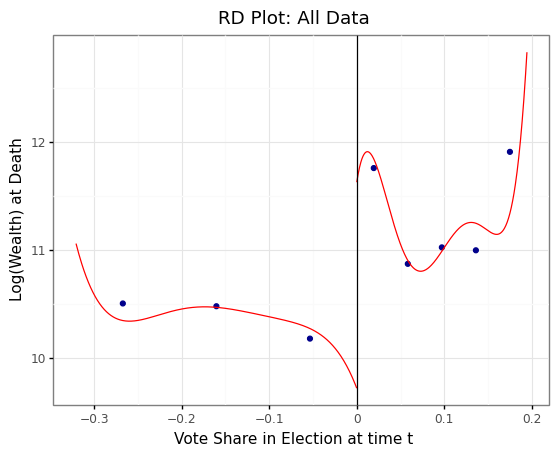


Call: rdplot
Number of Observations:                   581
Kernel:                               Uniform
Polynomial Order Est. (p):                  5

                                Left      Right
------------------------------------------------
Number of Observations           258        323
Number of Effective Obs          258        323
Bandwith poly. fit (h)         0.321      0.194
Number of bins scale               1          1
Bins Selected                      3          5
Average Bin Length             0.107      0.039
Median Bin Length              0.107      0.039
IMSE-optimal bins                3.0        5.0
Mimicking Variance bins         19.0       18.0

Relative to IMSE-optimal:
Implied scale                    1.0        1.0
WIMSE variance weight            0.5        0.5
WIMSE bias weight                0.5        0.5


In [117]:
rdplot(y=np.log(1+data_with_vars['Vermogen_deflated']), x=data_with_vars['margin'], binselect="es", p=5,
         title="RD Plot: All Data", 
         y_label="Log(Wealth) at Death",
         x_label="Vote Share in Election at time t")


In [10]:
data_with_vars.to_csv("../Data/analysis/unmatched_sample_with_vars.csv")

In [11]:
data_with_vars['Sterfdatum'] = data_with_vars['Sterfdatum'].apply(lambda x: pd.to_datetime(x, errors='coerce'))
data_with_vars2 = data_with_vars[(data_with_vars['Sterfdatum'] < pd.Timestamp('1928-01-01')) | (pd.isnull(data_with_vars['Sterfdatum']))]